<a href="https://colab.research.google.com/github/dnjhaha/AML/blob/master/finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Face recognition use CNN

Face recognition is a method of identifying or verifying the identity of an individual using their face.Essentially, the process of face recognition is performed in two steps. The first involves feature extraction and selection and the second is the classification of objects.
This notebook uses a deep convolutional neural network (CNN) to extract features from input images. 

- Detect, transform and crop the face on the input image. This ensures that faces are aligned before entering CNN. This preprocessing step is very important for the performance of neural network.
- CNN is used to extract 128 dimensional representation or embedding of human face from the aligned input image. In the embedding space, Euclidean distance directly corresponds to the measurement of face similarity.
-Compare the input embedding vector with the marked embedding vector in the database. Here, support vector machine (SVM) and KNN classifier play the role of database after the training of mark embedding vector. In this case, face recognition means using these classifiers to predict the tag, that is, the new input identity.

**Environment setup**

For running this notebook, install the tensorflow==1.14.0. 

In [1]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 70kB/s 
     |████████████████████████████████| 3.2MB 41.5MB/s 
     |████████████████████████████████| 491kB 39.4MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


Furthermore, you'll need a local copy of Dlib's face landmarks data file for running face alignment:

In [0]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

### Build CNN architecture and training the model

The CNN architecture used here is a variant of the NN4 architecture described in FaceNet: A Unified Embedding for Face Recognition and Clustering and identified as nn4.small2 model in the OpenFace project. 
This notebook uses a Keras implementation of that model whose definition was taken from the Keras-OpenFace project. The architecture details are useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the *embedding layer* from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in model.py. A Keras version of the nn4.small2 model can be created with `create_model()`.

In [3]:
from model import create_model

nn4_small2 = create_model()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

The OpenFace project provides pre-trained models]that were trained with the public face recognition datasets and CASIA-WebFace. The Keras-OpenFace project converted the weights of the pre-trained nn4.small2.v1 model to a binary format that can be loaded by Keras with `load_weights`:

In [0]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('nn4.small2.v1.h5')

### Custom dataset

To demonstrate face recognition on a custom dataset, a small dataset is used. It consists of 56 face images of [7 identities](images). The metadata for each image (file and identity name) are loaded into memory for later processing.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving images.zip to images.zip


In [0]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['images.zip']), "r")
zf.extractall()

In [0]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

### Face alignment

The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, we use [Dlib](http://dlib.net/) for face detection and [OpenCV](https://opencv.org/) for image transformation and cropping to produce aligned 96x96 RGB face images. By using the [AlignDlib](align.py) utility from the OpenFace project this is straightforward:

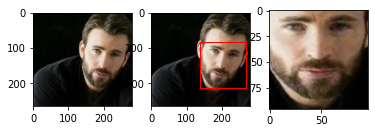

In [8]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[22].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

As described in the OpenFace [pre-trained models](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) section, landmark indices `OUTER_EYES_AND_NOSE` are required for model nn4.small2.v1. Let's implement face detection, transformation and cropping as `align_image` function for later reuse.

In [0]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Embedding vectors

Embedding vectors can now be calculated by feeding the aligned and scaled images into the pre-trained network.

In [0]:
def get_embeddings(img):
    embeddings = np.zeros((1, 128))
    try:
        img = (img / 255.).astype(np.float32)
    except TypeError:
        embeddings = None
    else:
        embeddings = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    
    return embeddings

Let's verify on a single triplet example that the squared L2 distance between its anchor-positive pair is smaller than the distance between its anchor-negative pair.

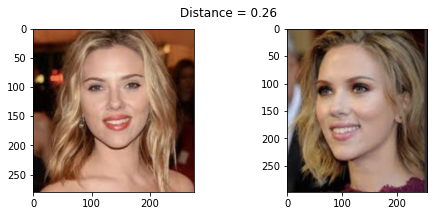

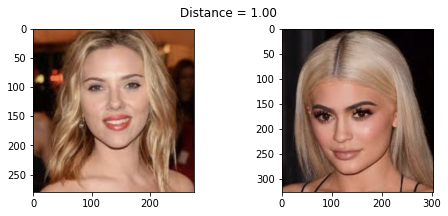

In [12]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(8, 11)
show_pair(8, 35)

As expected, the distance between the two images of black widow is smaller than the distance between an image of black widow and an image of kylie (0.26 < 1). But we still do not know what distance threshold is the best boundary for making a decision between *same identity* and *different identity*.

### Distance threshold

To find the optimal value for $\tau$, the face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either *same identity* or *different identity* and compared to the ground truth. Since we're dealing with skewed classes (much more negative pairs than positive pairs), we use the [F1 score](https://en.wikipedia.org/wiki/F1_score) as evaluation metric instead of [accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

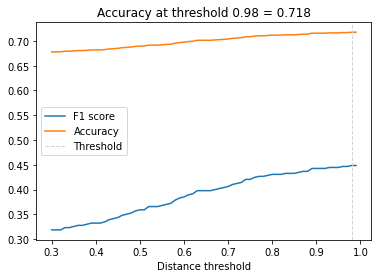

In [13]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

The face verification accuracy at $\tau$ = 0.58 is 95.6%. This is not bad given a baseline of 89% for a classifier that always predicts *different identity* (there are 450 pos. pairs and 4500 neg. pairs) but since nn4.small2.v1 is a relatively small model it is still less than what can be achieved by state-of-the-art models (> 99%). 

The following two histograms show the distance distributions of positive and negative pairs and the location of the decision boundary. There is a clear separation of these distributions which explains the discriminative performance of the network. One can also spot some strong outliers in the positive pairs class but these are not further analyzed here.

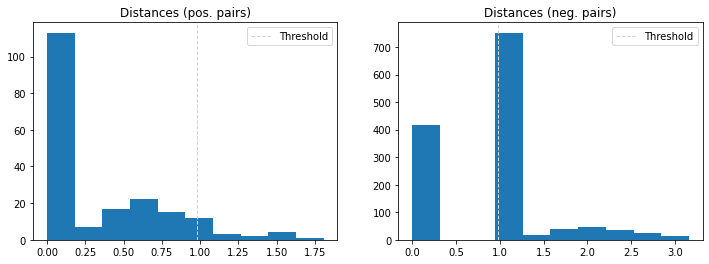

In [14]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

### Face recognition

Given an estimate of the distance threshold $\tau$, face recognition is now as simple as calculating the distances between an input embedding vector and all embedding vectors in a database. The input is assigned the label (i.e. identity) of the database entry with the smallest distance if it is less than $\tau$ or label *unknown* otherwise. This procedure can also scale to large databases as it can be easily parallelized. It also supports one-shot learning, as adding only a single entry of a new identity might be sufficient to recognize new examples of that identity.

A more robust approach is to label the input using the top $k$ scoring entries in the database which is essentially [KNN classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) with a Euclidean distance metric. Alternatively, a linear [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine) (SVM) can be trained with the database entries and used to classify i.e. identify new inputs. For training these classifiers we use 50% of the dataset, for evaluation the other 50%.

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]


svc = LinearSVC()


svc.fit(X_train, y_train)


acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'SVM accuracy = {acc_svc}')

SVM accuracy = 0.5714285714285714


the SVM classifier 57%. Let's use the SVM classifier to illustrate face recognition on a single example.

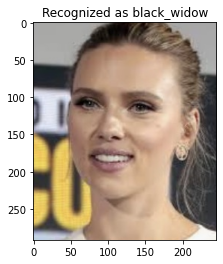

In [16]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 6

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

Seems reasonable :-) Classification results should actually be checked whether (a subset of) the database entries of the predicted identity have a distance less than $\tau$, otherwise one should assign an *unknown* label. This step is skipped here but can be easily added.



### References

- [1] [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832)
- [2] [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)